# Защита персональных данных клиентов

##  Введение
   
 - В проекте нужно защитить данные клиентов страховой компании «Хоть потоп»:  разработать и обосновать корректность работы такого метода преобразования данных, чтобы после преобразования было сложно восстановить персональную информацию, а также, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.

**План выполнения проекта:**
   
   - Загрузить и изучить данные.
   
   - Ответить на вопрос и обосновать решение:  
     
     - Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)
 
        -  a. Изменится. Привести примеры матриц.
        -  b. Не изменится. Указать, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.
        
         
   - Предложить алгоритм преобразования данных для решения задачи и обосновать, почему качество линейной регрессии не поменяется.
   
   - Запрограммировать этот алгоритм, применив матричные операции. Проверить, что качество линейной регрессии из sklearn не отличается до и после преобразования, применив метрику R2.

   -  Написать промежуточный и общий выводы.

## Загрузка и изучение данных

In [1]:
#! pip install phik==0.9.7

In [2]:
# загружаем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik

from sklearn.preprocessing import StandardScaler 
#from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# настраиваем отображение 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

In [3]:
# загружаем данные
try:
    data = pd.read_csv('/datasets/insurance.csv', sep=',')
except:
    data = pd.read_csv('/datasets/insurance.csv', sep=',')

In [4]:
# знакомимся с данными, выводим пять случайных строк, явные и относительные дубликаты и пропуски
def data_info(data):
    d = {'data' : data}
    for a, i in d.items():
        # дубликаты
        print('Датасет:',a,'абсолютное количество явных дубликатов:',i.duplicated().sum())    
        print('Датасет:',a,'относительное количество явных дубликатов:',i.duplicated().sum()/data.shape[0])
        # пропуски
        print('Датасет:',a,'абсолютное количество пропусков:')
        print(i.isna().sum().sort_values()) 
        print('Датасет:',a,'относительное количество пропусков:')    
        print((i.isna().sum()/data.shape[0]).sort_values())
        # строки и инфо
        display(i.sample(5))
        print()
        i.info()
# выводим         
data_info(data)  

Датасет: data абсолютное количество явных дубликатов: 153
Датасет: data относительное количество явных дубликатов: 0.0306
Датасет: data абсолютное количество пропусков:
Пол                  0
Возраст              0
Зарплата             0
Члены семьи          0
Страховые выплаты    0
dtype: int64
Датасет: data относительное количество пропусков:
Пол                  0.0
Возраст              0.0
Зарплата             0.0
Члены семьи          0.0
Страховые выплаты    0.0
dtype: float64


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
814,0,35.0,47700.0,4,0
3271,1,40.0,58200.0,0,0
3780,1,26.0,45600.0,3,0
507,0,32.0,34600.0,1,0
2953,1,25.0,40000.0,0,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


 - Датасет успешно загружен. В нем 5000 строк без пропусков, но с 3%-ми дубликатов. Все значения числовых типов. В столбце с возрастом значения почему-то не целочисленные.
 
 
 - Проверим дубликаты и удалим: они не окажут влияния на работу модели. 
 
 
 - Заменим тип float на int в столбце с возрастом и все типы числовых значений на более энергоэкономные. 

In [5]:
# выводим 10 строк с полными дубликатами
data[data.duplicated(keep=False)].sort_values(by='Зарплата').head(10)

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
2955,1,32.0,21600.0,0,0
2988,1,32.0,21600.0,0,0
361,0,50.0,24700.0,1,2
2869,0,50.0,24700.0,1,2
333,0,32.0,25600.0,1,0
4230,0,32.0,25600.0,1,0
1378,0,36.0,26400.0,0,0
2723,0,36.0,26400.0,0,0
1002,1,34.0,26900.0,0,0
1140,1,34.0,26900.0,0,0


In [6]:
# удаляем дубликаты
data.drop_duplicates(inplace=True, ignore_index=True)

#проверяем
print(data.duplicated().sum())
data.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                4847 non-null   int64  
 1   Возраст            4847 non-null   float64
 2   Зарплата           4847 non-null   float64
 3   Члены семьи        4847 non-null   int64  
 4   Страховые выплаты  4847 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 189.5 KB


In [7]:
# меняем тип данных с 64 на 32
def change_type(columns, type):
    data[columns
        ] = data[columns].astype(type)
    return data 

data = change_type(data.columns[2],'float32')
data = change_type(data.columns[[0,1,3,-1]],'int32')
# проверяем
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4847 entries, 0 to 4846
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                4847 non-null   int32  
 1   Возраст            4847 non-null   int32  
 2   Зарплата           4847 non-null   float32
 3   Члены семьи        4847 non-null   int32  
 4   Страховые выплаты  4847 non-null   int32  
dtypes: float32(1), int32(4)
memory usage: 94.8 KB


In [8]:
# смотрим уникальные значения в данных 
columns = data.select_dtypes(include='number')
def values_unique(data):
    for column in columns:
        values1 = data[column].unique()
        values2 = data[column].nunique()
        values3 = data[column].value_counts(normalize=True)
        print('Уникальные значения столбца:', column)
        print(values1)
        print('Количество уникальных значений столбца:', column)
        print(values2)
        print('Относительное распределение уникальных значений столбца:', column)
        print(values3)
        print()
        
values_unique(data)      

Уникальные значения столбца: Пол
[1 0]
Количество уникальных значений столбца: Пол
2
Относительное распределение уникальных значений столбца: Пол
0    0.501547
1    0.498453
Name: Пол, dtype: float64

Уникальные значения столбца: Возраст
[41 46 29 21 28 43 39 25 36 32 38 23 40 34 26 42 27 33 47 30 19 31 22 20
 24 18 37 48 45 44 52 49 35 56 65 55 57 54 50 53 51 58 59 60 61 62]
Количество уникальных значений столбца: Возраст
46
Относительное распределение уникальных значений столбца: Возраст
19    0.043945
25    0.042294
31    0.041675
22    0.041469
26    0.041469
27    0.041469
28    0.040437
32    0.040437
30    0.040437
29    0.040437
23    0.040231
21    0.039818
20    0.039200
33    0.038374
36    0.038374
24    0.036311
35    0.035692
34    0.035692
37    0.029503
39    0.028884
38    0.027852
41    0.025583
18    0.023932
40    0.022694
42    0.019187
43    0.015886
44    0.015267
45    0.015061
46    0.012379
47    0.009697
49    0.007634
50    0.005364
48    0.005364
52    0.00

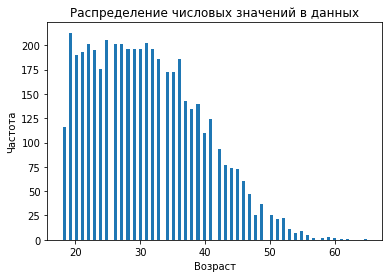

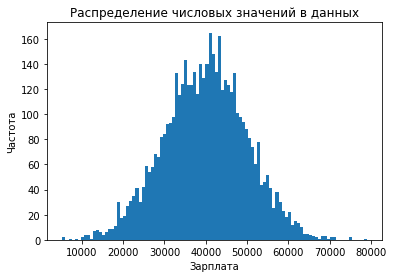

In [9]:
# смотрим столбцы с числовыми данными обучающего набора на графиках
columns_plot = ('Возраст','Зарплата')
def plot(data, kind):
    for column in columns_plot:     
        data[column].plot(bins=100, kind=kind)                         
    
        plt.grid=True
        plt.figsize =(12,4)
        plt.legend=False 
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.title('Распределение числовых значений в данных')
        plt.show()       
        
plot(data, 'hist')

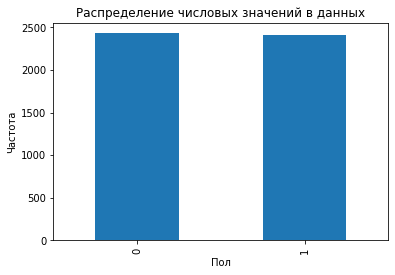

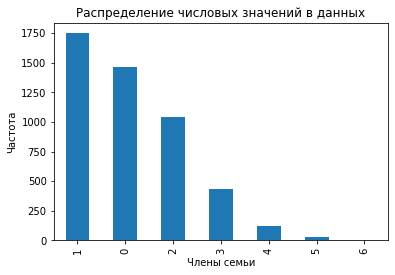

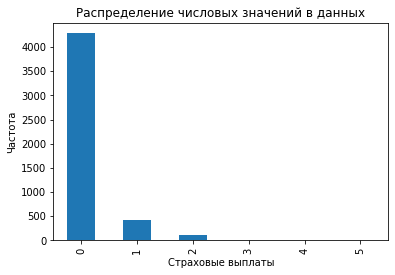

In [10]:
# смотрим столбцы с числовыми категориаьными данными обучающего набора на графиках
columns_plot = ('Пол', 'Члены семьи', 'Страховые выплаты')
def plot(data, kind):
    for column in columns_plot:     
        data[column].value_counts().plot(kind=kind)                         
    
        plt.grid=True
        plt.figsize =(12,4)
        plt.legend=False 
        plt.xlabel(column)
        plt.ylabel('Частота')
        plt.title('Распределение числовых значений в данных')
        plt.show()       
        
plot(data,'bar')

 - Аномалий в данных не наблюдается. Существует дисбаланс классов в признаках возраста, членов семьи и зарплаты. 
 
 
 - В целевом признаке существует существенный дисбаланс в сторону нулевого значения.   


 - Детальнее взглянем на возможные выбросы и распределение значений. 

In [11]:
# смотрим распределение значений в признаках
data.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,4847.000000,4847.000000,4847.000000,4847.000000,4847.000000
mean,0.498453,31.023932,39895.812500,1.203425,0.152259
std,0.500049,8.487995,9972.954102,1.098664,0.468934
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33200.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


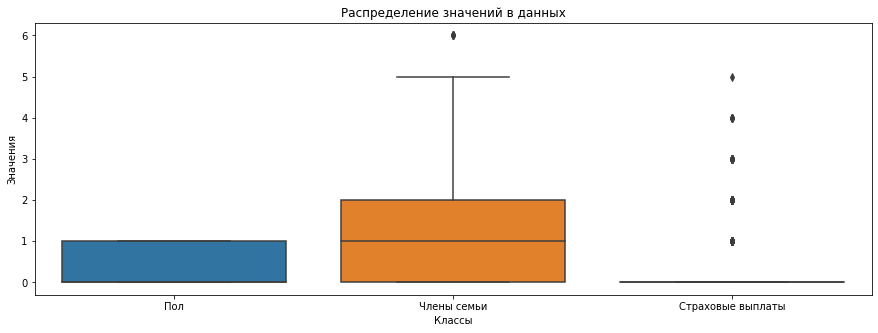

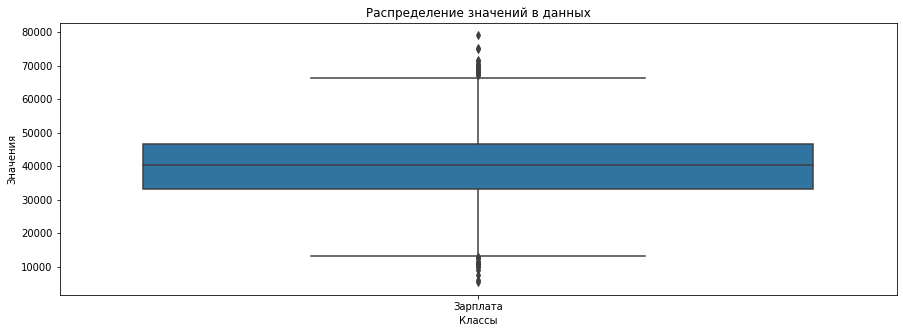

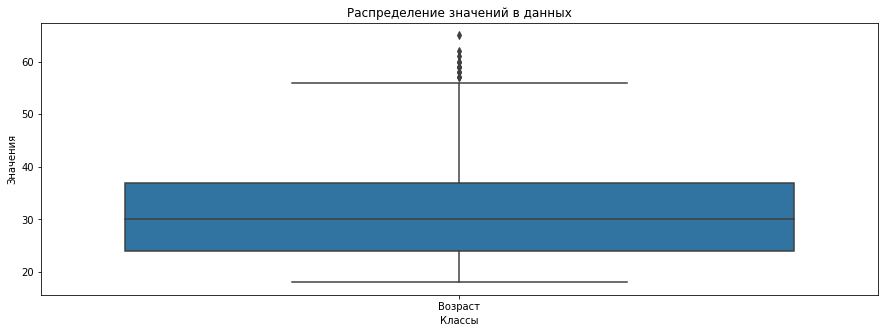

In [12]:
# создаем функцию для построения диаграмм разброса данных
def boxplotly(data):
    
    plt.figure(figsize=(15, 5))    
    sns.boxplot(data=data)
    plt.xlabel('Классы')
    plt.ylabel('Значения')
    plt.title('Распределение значений в данных')
    plt.show()   

# смотрим разброс в данных
columns = ['Пол', 'Члены семьи', 'Страховые выплаты']   
boxplotly(data[columns])
columns = ['Зарплата']
boxplotly(data[columns])
columns = ['Возраст']    
boxplotly(data[columns])

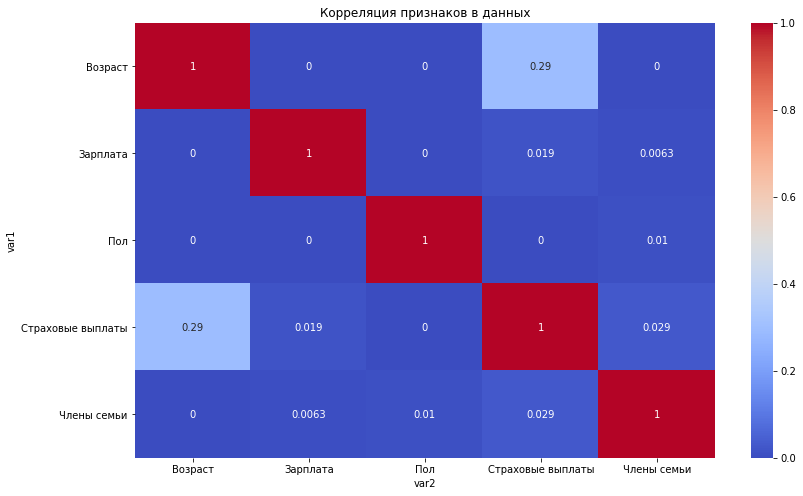

In [13]:
# строим матрицу корреляции данных
# выбираем колонки
col = ['Пол', 'Возраст', 'Зарплата', 'Члены семьи', 'Страховые выплаты']

# задаем матрицу корреляции
corr_matrix = data.phik_matrix(interval_cols=col, bins=(2))

# визуализируем матрицу корреляции
plt.figure(figsize=(13, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm')
plt.title('Корреляция признаков в данных')
plt.show() 

-  За исключением дисбаланса и немноголисленных выбросов, данные распределены нормально. 


-  Матрица корреляции ожидаемо не слишком информативная, однако можно увидеть существенную зависимость страховых выплат от возраста.  


-  Для улучшения качества предсказания модели, перед обучением масштабируем признаки. 

### Вывод 
   - Данные загружены и изучены. 

## Умножение матриц

### Рассчитаем, изменится ли качество линейной регрессии, если умножить признаки на случайную обратимую матрицу.

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** 

 - Качество предсказания линейной регрессии не изменится. 



**Обоснование:** 

 - Для доказательства утверждения, необходимо доказать, что предсказания обоих моделей тождественны: 
 
 
Сопоставим две формулы предсказания целевого признака (до преобразования и после):

$ a = Xw $

$ a'= Xw'=(XP)w',$

где $P$ — случайная обратимая матрица, на которую умножаются признаки.

Докажем, что $ a' =  a$.

Подставим в формулу обучения модели $XP$ вместо $X$ :  
 
 $ w' = ((XP)^T (XP))^{-1} (XP)^Ty =$ 
 
 $ = (P^TX^TXP)^{-1}P^TX^Ty = $ 
 
 $ = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty = $ 
 
 $ = P^{-1}(X^TX)^{-1}EX^Ty = $
 
 $ = P^{-1}(X^TX)^{-1}X^Ty = $
 
 $ = P^{-1}w$


Тогда: $w'(y)= P^{-1}w$

Подставим найденное значение в формулу обучения:

$a'= Xw'=(XP)w'= (XP)P^{-1}w = XPP^{-1}w = Xw$

Т.е. $a' = a$ 

ЧДТ

**О связи параметров линейной регрессии в исходной задаче и в преобразованной:**
 - Параметры линейной регрессии (w и w') в исходной задаче и в преобразованной  связаны через обратную случайную матрицу. 


### Вывод

- Ответили на вопрос задачи о матричном преобразовании признаков и обосновали решение.

## Алгоритм преобразования

- **План действий:**
   
   - 1. Создать модель;  
   
   - 2. Выделить из набора данных цель и признаки;

   - 3. Сгенеренрировать случайную обратимую матрицу равную по ширине ширине датафрейма - ключ шифрования; 
   
   - 4. Проверить обратимость матрицы по равенству определителя матрицы нулю, если матрица необратима, вернуться в пункт 3; 
    
   - 5. Произвести шифование признаков - матричное умножение признаков и ключа шифрования; 

   - 6. Обучить модель и получить предсказание на двух датасетах: с зашифрованными и не зашифрованными признаками;
   
   - 7. Сравнить полученные метрики.


- **Алгоритм кода:**


   - 1. Задать класс **LinearRegression**.


   - 2. Вызвать метод **fit()**, который примет на вход признаки и цель, а внутри метода:
   
      - 2.1 создать внутриклассовую переменную **self.P** со случайной обратимой матрицей, **равной по ширине ширине датафрейма** ;
      - 2.2 **проверить матрицу на обратимость** и, в случае ее необратимости (равенства определителя матрицы нулю), **создать новую**;
      - 2.3 создать переменную **X** - результат скалярного произведения признаков обучающей выборки (**train_features**) на **self.P**;
      - 2.4 добавить **единичный столбец** в **X**;
      - 2.5 создать переменную **y**, в которую передать данные целевого признака обучающей выборки (**train_target**).
      - 2.6 создать переменную **w** и записать в нее результаты выполнения формулы $w = (X^T X)^{-1} X^T y$ с использованием одноименных переменных метода **fit()**;      
      - 2.7 создать атрибуты **self.w** и **self.w0**;
      - 2.8 cоздать внутриклассовые переменные **self.w**, в которую передать все значения из переменной **w**, кроме нулевого, и переменную **self.w0**, которой передать нулевое значение **w**. 



   - 3. Вызвать метод **predict()**, который примет на вход признаки, а вернёт предсказание, а внутри метода:

      - 3.1 создать переменную **X** - скалярное произведение обучающей выборки (**test_features**) на **self.P**;
     
      - 3.2 найти предсказание как результат скалярного произведения переменной **X** на внутриклассовую переменную **self.w** с прибавлением внутриклассовой переменной **self.w0**, сохранив в переменную **predictions**;


   - 4. **Вычислить** метрику **R2**.



**Обоснование**

 - Докажем, что результаты функции потерь в исходной и преобразованной задачах тождественны.

Как было показано выше: 

$w'(y)= P^{-1}w$

Т.е., параметры линейной регрессии (w и w') в исходной задаче и в преобразованной  связаны через обратную случайную матрицу. 

Поэтому, **если** задачи обучения до и поcле преобразования, соответственно, выглядят так: 

$w = argmin_w MSE(Xw,y)$

$w'= argmin _{w'} MSE(XPw',y)$
 
**а:**

$w'(y)= P^{-1}w$

**то:** 

$w'= argmin _{w'} MSE(XPw',y) = argmin _{w'} MSE(XPP^{-1}w, y) = argmin _{w'} MSE(Xw,y)$ 

**следовательно:**

$argmin_w MSE(Xw,y) = argmin _{w'} MSE(Xw,y)$  

ЧТД
 
  - **Результаты разных задач** обучения **тождественны**. То есть в обоих случаях (с преобразованием и без) в результате обучения **минимум будет** достигаться **при одном и том же значении функции потерь**.  

### Вывод

- Составили и обосновали алгоритм матричного преобразования признаков и работы модели.

## Проверка алгоритма

In [14]:
# создаем класс "LinearRegression" и его методы
# для предсказания результатов методом линейной регрессии
class LinearRegression:
    
    # метод, включающий использование 
    # случайной обратимой матрицы для защиты данных
    def keep(self, keeping):
        if keeping == True:
            self.keep = True 
        else:
            self.keep = False     
    
    # метод обучения 
    def fit(self, train_features, train_target):
        n = 0
        while n == 0:
            self.P = np.random.normal(size=(train_features.shape[1], 
                                            train_features.shape[1]))
            n = np.linalg.det(self.P)            
        if self.keep == True: 
            X = train_features @ self.P
            X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        else:    
            X = np.concatenate((np.ones((train_features.shape[0], 1)),
                                         train_features), axis=1)            
        y = train_target    
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    # метод предсказания
    def predict(self, test_features):
        if self.keep == True:
            X = test_features @ self.P
            P = self.P
        else:
            X = test_features
            P = self.P
        return X.dot(self.w) + self.w0, P     

In [15]:
# готовим данные для использования в модели
# выделяем признаки и цель
features = data.drop('Страховые выплаты', axis=1)
target = data['Страховые выплаты']

# формируем выборки: обучающую(75%) и тестовую(25%)
features_train, features_test, target_train, target_test = train_test_split(
                                  features, 
                                  target,
                                  test_size=0.25,
                                  random_state=12345    
)

# масштабируем признаки 
scaler = StandardScaler()
scaler.fit(features_train)
features_train = scaler.transform(features_train)
features_test = scaler.transform(features_test)

In [16]:
# реализуем модель без защиты данных
model = LinearRegression()
model.keep(False)
model.fit(features_train, target_train)
predictions, P = model.predict(features_test)
R2_free = r2_score(target_test, predictions)
print('R2 исходной модели:', R2_free)

R2 исходной модели: 0.4230772749214825


In [17]:
# реализуем модель с защитой данных
model = LinearRegression()
model.keep(True)
model.fit(features_train, target_train)
predictions, P = model.predict(features_test)
R2_keep = r2_score(target_test, predictions)
print('R2 преобразованной модели:', R2_keep)

R2 преобразованной модели: 0.4230772749214827


In [18]:
# сравнение показателей моделей
print('Показатели моделей')
print('R2 исходной модели:', R2_free)
print('R2 преобразованной модели:', R2_keep)
print('Разница:', R2_free-R2_keep)

Показатели моделей
R2 исходной модели: 0.4230772749214825
R2 преобразованной модели: 0.4230772749214827
Разница: -2.220446049250313e-16


 - **Разница** показателей **R2** между моделями с защищенными и не защищенными данными **стремится к нулю**. Можно сделать вывод о том, что **защиту данных с помощью случайной обратимой матрицы использовать допустимо**.

### Вывод 

- **Проверили алгоритм на практике**: создали и обучили модель линейной регрессии на выборках с защищенными и незащищенными данными, получили предсказания и сравнили полученные показатели R2. **Значения показателей практически не отличаются**. 

## Проверка матричного шифрования/дешифрования

 - Зашифруем и расшифруем данные с помощью соответственно прямой и обратной обратимой случайной  матрицы.
 
 
 - Проверим правильность дешифровки векторным вычитанием. 

In [19]:
# получаем данные:
# сохраняем случайную обратимую матрицу
matrix_random = P 
# создаем обратную матрицу
matrix_inv = np.linalg.inv(matrix_random)

# кодируем и декодируем признаки
features_keep = features@matrix_random
features_inv = abs(round(features_keep@matrix_inv))
features_inv.columns = features.columns

In [20]:
# выводим данные до и после преобразования
print('Данные до шифрования:')
display('Размер датафрейма:',features.shape, 'Первые пять строк:', features.head())
print()
print('Данные после шифрования:')
display('Размер датафрейма:', features_keep.shape, 'Первые пять строк:', features_keep.head())
print()
print('Квадратная случайная матрица:')
print(matrix_random)
print()
print('Обратная случайной матрица:')
print(matrix_inv)
print()
print('Данные после дешифрования:')
display('Размер датафрейма:', features_inv.shape, 'Первые пять строк:', features_inv.head())
print()

# проверяем корректность дешифровки
print('Сумма разности исходного и дешифрованного датафремов:')
print((features-features_inv).sum())

Данные до шифрования:


'Размер датафрейма:'

(4847, 4)

'Первые пять строк:'

,Пол,Возраст,Зарплата,Члены семьи
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0



Данные после шифрования:


'Размер датафрейма:'

(4847, 4)

'Первые пять строк:'

,0,1,2,3
0,-40031.123135,-115693.359524,802.466565,-81071.114195
1,-30655.255021,-88613.805182,633.662998,-62109.941792
2,-16939.277595,-48965.418476,355.199302,-34323.492182
3,-33663.490837,-97287.318519,657.057066,-68160.456746
4,-21060.798011,-60868.937126,430.592556,-42659.476280



Квадратная случайная матрица:
[[-0.73038033  0.5244508  -0.62242475  0.49607059]
 [ 0.86604511  1.54689701  1.27405088  0.09634944]
 [-0.80782823 -2.33382279  0.01515485 -1.63458506]
 [ 2.37977566  0.30339261 -0.82760022 -0.14148628]]

Обратная случайной матрица:
[[-0.61508859 -0.15766939 -0.2146549   0.21594301]
 [ 1.29006803  0.7880033   0.41628267  0.25047689]
 [-1.03120408  0.01449727 -0.27613474 -0.41549963]
 [-1.54750709 -1.04703671 -1.1026104  -0.46819855]]

Данные после дешифрования:


'Размер датафрейма:'

(4847, 4)

'Первые пять строк:'

,Пол,Возраст,Зарплата,Члены семьи
0,1.0,41.0,49600.0,1.0
1,0.0,46.0,38000.0,1.0
2,0.0,29.0,21000.0,0.0
3,0.0,21.0,41700.0,2.0
4,1.0,28.0,26100.0,0.0



Сумма разности исходного и дешифрованного датафремов:
Пол            0.0
Возраст        0.0
Зарплата       0.0
Члены семьи    0.0
dtype: float64


### Вывод

 - Шифрование и дешифрование прошло успешно: данные в зашифрованном датафрейме изменились, исходный датафрейм и дешифрованный после преобразований абсолютно идентичны. 

## Общий вывод

-  В процессе работы над проектом мы:
   
   - Загрузили и изучили данные;
   
   - Ответили на вопрос задачи о матричном преобразовании признаков и обосновали решение;
   
   - Составили и обосновали алгоритм матричного преобразования признаков и работы модели линейной регрессии;
   
   - Проверили алгоритм на практике;
   
   - Проверили корректность матричного шифрования и дешифрования датафрейма.
 
 
- **Резюме:**

  - **Качество предсказания линейной регрессии** на выборках с незащищенными(не преобразованными) и с защищенными (преобразованными) данными **не изменилось**. Следовательно, **защиту данных** с помощью случайной обратимой матрицы **использовать допустимо**.
    